# Recommendations Model

In [103]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

import os
from json import loads, dumps

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity



#os.environ["JAVA_HOME"] = "/Users/juliafrench/Downloads/jdk-21.0.2.jdk/Contents/Home/"
#os.environ["SPARK_HOME"] = "/Users/juliafrench/Documents/apache-spark/3.5.0/libexec"

#localStorage = localStoragePy('movie_app', 'text')

from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext
sc


<SparkContext master=local[*] appName=pyspark-shell>

Import data, transform for cosine similarity

In [92]:
def movieTable():
    sparkDF = spark.read.csv('/Users/juliafrench/Documents/MovieRecc/IMDb_Clean_CSV.csv', header=True, inferSchema=True)
    df = sparkDF.toPandas()

    return df


# Concatenate the features into one string (ensure these columns exist in your DataFrame)
def transformClean():

    dataframe = movieTable()

    dataframe['combined_features'] = dataframe['Genre'] + ' ' + dataframe['Sub_Genre'] + ' ' + dataframe['Director'] + ' ' + dataframe['Year'].astype(str)

    # Convert textual data to numerical data using TF-IDF
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(dataframe['combined_features'])

    # Compute the cosine similarity
    cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

    return cosine_sim

Function to get recommendations from a list of ids.

In [7]:
def getReccomendations(ids, numRec):
    ids = ids
    cosine_sim = transformClean()
    num_recommendations = numRec

    df = movieTable()
    movieDF = df
    movieDF['combined_features'] =  movieDF['Genre'] + ' ' + movieDF['Sub_Genre'] + ' ' + movieDF['Director'] + ' ' + movieDF['Year'].astype(str)

    recommendations = []
    recs = []
    for movie_id in ids:
        print(movie_id)
        # Get the index of the movie that matches the ID
        idx = movieDF.index[movieDF['movieID'] == movie_id]
        if len(idx) > 0:
            idx = idx[0]
            # Get the pairwise similarity scores
            sim_scores = list(enumerate(cosine_sim[idx]))

            # Sort the movies based on similarity scores
            sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

            # Get the scores of the most similar movies
            sim_scores = sim_scores[1:num_recommendations+1]

            # Get the movie indices
            movie_indices = [i[0] for i in sim_scores]

              # Add recommendations for this movie to the list
            recommendations.append(movieDF['movieID'].iloc[movie_indices].tolist())
        else:
            recommendations.append([])

            # Movie not found in the dataset

        recs = recommendations

        flat_list = []
        for row in recs:
            flat_list.extend(row)

        res = []
        [res.append(x) for x in flat_list if x not in res]

        rows = df[df['movieID'].isin(res)]

    return rows

Function that uses the list of ids returned from user selected movies, and returns the recommendations from getReccomendations()

In [8]:

def selToList(li):
    li = li

    ids = [int(i) for i in li]


    numRec = 10

    numRec = 10

    recommendations = getReccomendations(ids, numRec)
    return recommendations

id_list = (1, 5, 8)

print(selToList(id_list))

1
5
8
      movieID                                              Title  Year  \
95         95                                  A Christmas Carol  2009   
128       128                                      A Mighty Wind  2003   
134       134                             A Night at the Roxbury  1998   
363       363                                   Army of the Dead  2021   
385       385                                          Astro Boy  2009   
492       492                 Batman v Superman: Dawn of Justice  2016   
493       493  Batman v Superman: Dawn of Justice (Ultimate E...  2016   
604       604                                        Black Death  2010   
1071     1071                                   Dawn of the Dead  2004   
1087     1087                                   Dead Man's Shoes  2004   
1534     1534                                          Following  1998   
2123     2123                                     Iron Man Three  2013   
2252     2252                   

# Model Testing

Create Samples

In [78]:
allIds = list(range(0, 5561))

i = list(range(1, 11))

samples = []
oneId = []
twoId = []
threeID = []
fourID = []
fiveID = []

for x in i:
    ids = random.choices(allIds, k=1)
    oneId.append(ids)

for x in i:
    ids = random.choices(allIds, k=2)
    twoId.append(ids)

for x in i:
    ids = random.choices(allIds, k=3)
    threeID.append(ids)

for x in i:
    ids = random.choices(allIds, k=4)
    fourID.append(ids)

for x in i:
    ids = random.choices(allIds, k=5)
    fiveID.append(ids)



Cosine Sim function

In [10]:
def calculate_similarity(movie1, movie2, features):
    combined_features1 = ' '.join([str(movie1[feature]).lower().strip() for feature in features])
    combined_features2 = ' '.join([str(movie2[feature]).lower().strip() for feature in features])
    tfidf = TfidfVectorizer().fit_transform([combined_features1, combined_features2])
    cosine_sim = cosine_similarity(tfidf)[0][1]
    return cosine_sim

# 1. Single ID test 
Uses oneId sample list

In [45]:
def get_avgSingle(df, movie_id, features, num_recommendations=10):
    movie_row = df[df['movieID'] == movie_id].iloc[0]
    similarities = df.apply(lambda x: calculate_similarity(movie_row, x, features), axis=1)
    top_indices = similarities.nlargest(num_recommendations + 1).index
    filtered_ind = [v for v in top_indices if v != movie_id]
    top_similarities = similarities.iloc[filtered_ind]
    avg_similarity = np.mean(top_similarities)
    return(filtered_ind, avg_similarity)


Returns dataframe of average similarity for each sample.

In [137]:

features = ['Genre', 'Sub_Genre', 'Year']
df = movieTable()

movie_infoSingle = []

for x in oneId:
    for movie_id in x:
        top_indices, avg_similarity = get_avgSingle(df, movie_id, features)
        movie_infoSingle.append({'movieID': movie_id,'topRecs': top_indices, 'avg_similarity': avg_similarity,})

avgSimsOne = pd.DataFrame(movie_infoSingle)
avgSimsOne['n'] = 1
avgSimsOne




,movieID,topRecs,avg_similarity,n
0,128,"[3552, 933, 278, 310, 722, 1297, 1303, 2460, 3...",0.715970,1
1,619,"[427, 1456, 1898, 3477, 3942, 973, 2961, 4972,...",0.853549,1
2,4903,"[152, 1499, 1723, 1779, 1849, 2764, 3010, 3577...",0.583798,1
3,1214,"[446, 758, 759, 940, 1169, 1754, 4145, 4195, 4...",0.602975,1
4,1193,"[352, 1522, 4202, 355, 1049, 1091, 1655, 1963,...",0.843560,1
5,3484,"[1237, 1118, 2309, 2578, 5422, 4513, 103, 201,...",0.679137,1
6,4986,"[1046, 2996, 927, 2894, 4019, 5482, 3320, 4555...",0.745806,1
7,2423,"[1068, 1352, 1437, 1941, 2202, 4434, 5527, 108...",0.932954,1
8,2674,"[2120, 2747, 27, 162, 218, 275, 333, 347, 645,...",0.660031,1
9,5461,"[2863, 5525, 11, 84, 85, 234, 240, 264, 374, 399]",0.660031,1


# 2. Multiple IDs

Applied on twoID, threeID, fourID, and fiveID

Get the top n-recommendations per sample.

In [56]:
def get_avgMulti(df, movie_id, features, num_rec):
    topIDs = []
    num_rec = num_rec
    for j in movie_id:
        movie_row = df[df['movieID'] == j].iloc[0]
        similarities = df.apply(lambda x: calculate_similarity(movie_row, x, features), axis=1)
        top_indices = similarities.nlargest(num_rec + 1).index
        filtered_ind = [v for v in top_indices if v != j]
        topIDs.append(filtered_ind)


    return(topIDs)

For each sample in list:
- calculate similarity between each id in sample and each top in sample
- average all per sample

In [69]:
features = ['Genre', 'Sub_Genre', 'Year']
df = movieTable()

def getSims(sample, tops):
    
    # Compute similarity scores for the entire sample
    tops = tops
    all_scores = []
    for x in sample:
        sample_movie = df[df['movieID'] == x].iloc[0]
        scores = []
        for rec_id in tops:
            # Check if there are any rows with the current rec_id
            temp_df = df[df['movieID'] == rec_id]
            if not temp_df.empty:
                # If the DataFrame is not empty, calculate the similarity
                sim_score = calculate_similarity(sample_movie, temp_df.iloc[0], features)
                scores.append(sim_score)
            else:
                # Handle the case where no matching movieID is found
                scores.append(0)  # For example, assuming a similarity of 0
            all_scores.extend(scores)

    avg_sim_score = sum(all_scores) / len(all_scores) if all_scores else 0  # Calculate average score for this sample

    return(avg_sim_score)

For each sample in twoID:
- Gets top 10 similar movies for each sample id: get_avgMulti()
- Combines all 20 into one list and removes duplicates. Therefore, there will be 10-20 recommendations per sample.
- Calculates similarity between each id in sample and each top in sample, then averages them: getSims()

In [85]:

features = ['Genre', 'Sub_Genre', 'Year']
df = movieTable()

def getTops(id_list, num_rec):
   id_list = id_list
   allTops2 = []
   num_rec = num_rec
   for x in id_list:
      topIds = get_avgMulti(df, x, features, num_rec)

      # Combine all into list and remove duplicates
      flat_list = []
      for i in topIds:
         flat_list.extend(i)

      flatIDs = []
      [flatIDs.append(k) for k in flat_list if k not in flatIDs]

      # get similarities and average
      avg_sim_score = getSims(x, flatIDs)

      allTops2.append({
            'movieID': x,
            'topRecs': flatIDs,
            'avg_similarity': avg_sim_score
        })
      
   # Convert to DataFrame and print results
   allTopIDs = pd.DataFrame(allTops2)
   return(allTopIDs)




In [104]:

avgSimsTwo = getTops(twoId, 10)
print(avgSimsTwo)


        movieID                                            topRecs  \
0  [5521, 4750]  [19, 25, 26, 41, 44, 77, 78, 108, 114, 122, 14...   
1   [4999, 928]  [2101, 3691, 3126, 20, 238, 306, 317, 318, 319...   
2  [4140, 3716]  [2957, 4965, 31, 308, 361, 474, 989, 1455, 292...   
3   [481, 3676]  [1029, 1141, 2089, 4160, 4633, 3049, 3510, 236...   
4   [2523, 466]  [1545, 292, 1027, 1229, 1552, 1559, 2132, 2463...   
5  [3415, 2864]  [3345, 2700, 328, 404, 500, 623, 789, 837, 877...   
6   [5318, 737]  [2386, 2648, 2687, 590, 938, 991, 1087, 2436, ...   
7  [4105, 5452]  [201, 4679, 2848, 4730, 399, 736, 979, 1061, 1...   
8  [5336, 5023]  [4368, 5242, 54, 69, 83, 98, 123, 142, 146, 15...   
9  [2675, 3489]  [2084, 27, 120, 162, 347, 472, 732, 871, 889, ...   

   avg_similarity  
0        0.544034  
1        0.387729  
2        0.473833  
3        0.314352  
4        0.389559  
5        0.408519  
6        0.417879  
7        0.431187  
8        0.540120  
9        0.493309  


In [105]:
avgSimsThree = getTops(threeID, 5)
print(avgSimsThree)

              movieID                                            topRecs  \
0  [1666, 3045, 5116]  [741, 748, 1032, 1073, 1664, 3285, 649, 891, 9...   
1   [2414, 549, 1478]  [2983, 3258, 4099, 1604, 1708, 13, 195, 228, 2...   
2  [1012, 3056, 4818]  [171, 548, 1289, 2366, 2611, 2084, 5522, 4635,...   
3    [402, 730, 1478]  [2104, 5096, 202, 330, 331, 765, 1410, 2683, 3...   
4   [5048, 2468, 930]  [59, 106, 132, 317, 334, 786, 3450, 5454, 7, 3...   
5  [2931, 2834, 4842]  [1888, 2743, 2754, 2973, 3055, 1351, 2295, 365...   
6  [3970, 1015, 1781]  [26, 78, 995, 1591, 2418, 3512, 3023, 4418, 47...   
7  [3467, 1070, 5490]  [266, 137, 149, 348, 1440, 3744, 525, 550, 176...   
8  [2668, 5176, 1789]  [70, 349, 408, 602, 693, 3804, 13, 195, 228, 2...   
9  [2152, 4118, 3740]  [1383, 1501, 2264, 3506, 5102, 190, 1228, 1277...   

   avg_similarity  
0        0.279989  
1        0.282215  
2        0.338778  
3        0.429959  
4        0.316350  
5        0.507210  
6        0.420891  
7  

In [106]:
avgSimsFour = getTops(fourID, 3)
print(avgSimsFour)

                    movieID  \
0   [3709, 376, 4659, 2619]   
1   [1255, 3006, 3539, 320]   
2  [1166, 2310, 2296, 3456]   
3   [102, 3870, 1591, 1269]   
4   [1646, 4584, 4776, 722]   
5   [3397, 2409, 2533, 299]   
6   [306, 2071, 2121, 4641]   
7   [880, 1836, 3692, 5155]   
8  [3992, 5341, 5438, 5380]   
9  [1134, 2407, 2319, 3816]   

                                             topRecs  avg_similarity  
0  [245, 1354, 2633, 2682, 857, 1536, 2399, 3094,...        0.455364  
1  [196, 1514, 2524, 164, 1755, 4417, 811, 1584, ...        0.279425  
2  [2805, 2840, 4686, 2337, 100, 529, 124, 484, 9...        0.247952  
3  [1681, 1889, 2090, 504, 3351, 3448, 26, 78, 99...        0.414955  
4  [1661, 201, 4679, 1336, 4177, 862, 2619, 1015,...        0.289955  
5  [224, 225, 1825, 2907, 3811, 4159, 2035, 2380,...        0.289786  
6  [20, 238, 317, 692, 982, 4413, 432, 2233, 3087...        0.208007  
7  [1960, 2757, 4096, 3610, 238, 351, 5381, 524, ...        0.277269  
8  [245, 1354, 2633

In [107]:
avgSimsFive = getTops(fiveID, 2)
print(avgSimsFive)

                          movieID  \
0    [2606, 3656, 68, 2016, 1851]   
1    [27, 3510, 4238, 5095, 5168]   
2     [249, 474, 1317, 564, 4973]   
3  [4597, 4344, 5041, 2058, 3416]   
4  [2469, 4097, 2929, 3600, 1536]   
5   [4003, 709, 4863, 3156, 1870]   
6  [4717, 4190, 2481, 4438, 2367]   
7   [1391, 2726, 743, 1639, 3810]   
8  [4558, 4375, 1415, 3964, 5367]   
9   [5536, 2918, 4264, 4584, 564]   

                                             topRecs  avg_similarity  
0  [44, 477, 535, 399, 1721, 3453, 199, 239, 232,...        0.333170  
1  [871, 4907, 3049, 1777, 2690, 2, 417, 1534, 66...        0.356267  
2  [1752, 1913, 31, 361, 1658, 5539, 667, 2882, 3...        0.283762  
3  [2446, 27, 3482, 652, 1219, 4184, 48, 298, 448...        0.265878  
4  [0, 451, 2343, 5245, 638, 25, 628, 760, 749, 2...        0.433280  
5  [4551, 4812, 232, 956, 245, 1354, 2633, 2479, ...        0.277027  
6  [4741, 48, 3045, 3285, 5045, 5197, 738, 4856, ...        0.249705  
7  [4721, 99, 4749, 1467

In [149]:
sampleAvg = pd.concat([avgSimsTwo, avgSimsTwo, avgSimsThree, avgSimsFour, avgSimsFive], axis=0)
sampleAvg['n'] = sampleAvg['movieID'].apply(len)
sampleAvg2 = pd.concat([sampleAvg, avgSimsOne])
sampleAvg2
sampleAvg2 = sampleAvg2.drop(['movieID', 'topRecs'], axis=1)



# Averages Box Plot


/var/folders/6f/pl962ydj69n83g5xbrl18kgw0000gn/T/ipykernel_59301/738841040.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='n', y='avg_similarity', data=sampleAvg2, palette=my_pal).set(


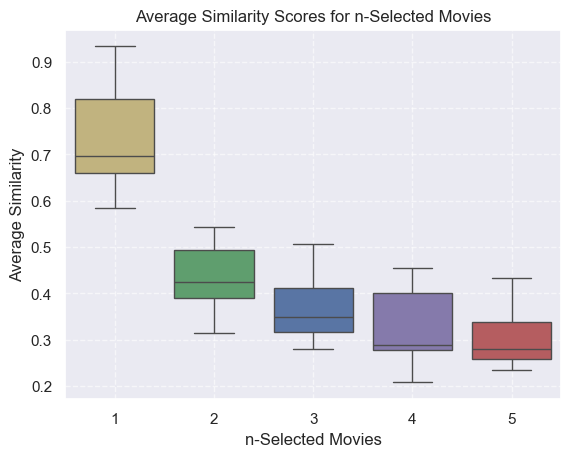

In [148]:

# Plotting the boxplot

my_pal = {"1":"y", "2": "g", "3": "b", "4":"m", "5":"r"}

sns.boxplot(x='n', y='avg_similarity', data=sampleAvg2, palette=my_pal).set(
    xlabel='n-Selected Movies',
    ylabel='Average Similarity')
plt.title('Average Similarity Scores for n-Selected Movies')
sns.set_theme(style="darkgrid")

plt.grid(True, linestyle='--', alpha=0.6)
